> Created on Sat Sep 30 14:59:20 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.9-C 强化学习——多智能体强化学习（multi-agents reinforcement learning，MARL）

## 3.9.1 

### 3.9.1.1

In [36]:
import numpy as np
import torch
from matplotlib import pyplot as plt

tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
       dtype=torch.uint8)


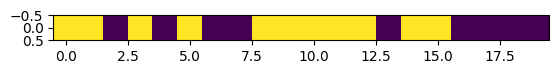

In [54]:
def init_grid(size=(10,)):
    grid = torch.randn(*size)
    grid[grid > 0] = 1
    grid[grid <= 0] = 0
    grid = grid.byte() #A
    return grid

def get_reward(s,a): #B
    r = -1
    for i in s:
        if i == a:
            r += 0.9
    r *= 2.
    return r

size=(20,)
grid = init_grid(size=size)
print(grid)
plt.imshow(np.expand_dims(grid,0));

---